Few key observations
- If both and non-encrypted files are base-32 encoded, accuracy drops really low.
   * Even in this case, fourier analysis (specifically autocorrelation and mean) provide good discrminators
   * Renyi's entropy at alpha=infinity gives good discrimination
   * Overall we see around 13% improvement in F1-score
- Specifically for webpfiles
   * We see that higher moments of around 14 gives a good discrimination
   * Fourier analysis still gives benefits here
- For webpfiles where both unencrypted and encrypted content are base32 encrypted
   * Fourier analysis is still beneficial
- For Non-webp files where plaintext is not base-32 encrypted
   * Accuracy is decent with just the base parameters, but with fourier analysis, we can close to perfect detection


## Implementation <a class="anchor" id="implementation">
    
[top](#Contents)

In [1]:
import pandas as pd
import numpy as np
import scipy
from scipy import stats

from functools import lru_cache

import gc

import sklearn
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, accuracy_score, recall_score

import matplotlib.pyplot as plt
import glob

import tqdm
from multiprocessing.pool import ThreadPool, Pool

plt.rcParams["figure.figsize"] = (20,20)

### List of files <a class="anchor" id="list-of-files">

[top](#Contents)

In [2]:
!ls

Iteration_2.1_EXT2_RF_weighted_importances.ipynb
expanded.plaintext.base32.csv.gz
expanded.pyencrypted_v1.b32.csv.gz
expanded.pyencrypted_v1.csv.gz
expanded.pyencrypted_v2.base32.csv.gz
expanded.pyencrypted_v2.csv.gz
iteration_2.1_compare_base32_alternate_encryption_scheme.ipynb
iteration_2.1_compare_base32_logistic_regression.ipynb
plaintext.base32.combined.csv.gz
plaintext.combined.csv.gz
plaintext.expanded.csv.gz
simple-average.pickle
weighted-results.pickle
weighted-scaled-results.pickle


### Utility utilities<a class="anchor" id="gc">
    
[top](#Contents)

In [3]:
def call_gc():
    for i in range(3):
        for j in range(3):
            gc.collect(j)
            
import pickle
def save_results(filename, column, all_results):
    save_tuple = (column, all_results,)
    with open(filename, "wb") as f:
        pickle.dump(save_tuple, f, pickle.HIGHEST_PROTOCOL)

### Selection of columns <a class="anchor" id="select-columns">
    
This function is used to select the columns.
There are three different configurations:
    
    1. Baseline - statistics like autocorrelation, shannon entropy, chi-square etc. are used
    
    2. Advanced - More statistics like moments, Tsallis and Renyi entropy, higher moments etc.
    
    3. Fourier - Some statistics of the Fourier Power Spectrum distribution
    
[top](#Contents)

In [4]:
def get_columns(thisdf):
    baseline_columns = [c for c in thisdf.columns if c.startswith('baseline') and "head" not in c and "tail" not in c]
    baseline_columns = [c for c in baseline_columns if "filesize" not in c]
    baseline_columns = [c for c in baseline_columns if "begin" not in c and "end" not in c]

    advanced_columns = [c for c in thisdf.columns if "advanced" in c]
    advanced_columns = [c for c in advanced_columns if "begin" not in c and "end" not in c]
    advanced_columns = [c for c in advanced_columns if "head" not in c and "tail" not in c]
    advanced_columns = [c for c in advanced_columns if "start" not in c]
    advanced_columns_only = list(set(advanced_columns))
    advanced_columns = list(set(advanced_columns + baseline_columns))

    fourier_columns = [c for c in thisdf.columns if "fourier" in c and "value" not in c]
    fourier_columns = [c for c in fourier_columns if "1byte" in c]
    fourier_columns = [c for c in fourier_columns if "begin" not in c and "end" not in c]
    fourier_columns = [c for c in fourier_columns if "head" not in c and "tail" not in c]
    fourier_columns = [c for c in fourier_columns if "start" not in c]
    fourier_columns_only = list(set(fourier_columns))
    fourier_columns = list(set(advanced_columns + fourier_columns))
    
    baseline_and_advanced = list(set(baseline_columns + advanced_columns_only))
    baseline_and_fourier = list(set(baseline_columns + fourier_columns_only))
    advanced_and_fourier = list(set(advanced_columns_only + fourier_columns_only))
    
    return {\
        "fourier": fourier_columns,\
    }

### Function to compare the three selections of columns for a given dataset <a class="anchor" id="compare-fn">
    
For the three different sets of measurements described above, compare all the three sets for their f1 score
    
[top](#Contents)

In [5]:
USE_ASYNC = False
N_SPLITS=5

def get_weighted_feature_importances_inloop(f1_scores, feature_importances):
    """
    First scale the importances so that the column with the maximum
    importance has an importance 1.
    
    Next find the weighted mean w.r.t. the f1-score
    """
    out_importances = np.zeros(len(feature_importances[0]))
    for f1, importance in zip(f1_scores, feature_importances):
        importance = importance / np.max(importance)
        importance = importance * f1
        out_importances = out_importances + importance
    out_importances /= sum(f1_scores)
    return out_importances

def get_kfold_f1_score(name, collist, X, y):
    skf = StratifiedKFold(n_splits=N_SPLITS, random_state=42, shuffle=True)
    f1_scores = []
    precision_scores = []
    recall_scores = []
    accuracy_scores = []
    feature_importances = []
    X = X[collist].to_numpy()
    y = y.to_numpy()
    call_gc()
    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        rfc = RandomForestClassifier(n_jobs=10, random_state=42)
        estimators = [\
                      ('std,', MinMaxScaler()), \
                      ('RandomForestClassifier', rfc)]
        pipeline = Pipeline(estimators)
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        f1_scores.append(f1_score(y_test, y_pred))
        recall_scores.append(recall_score(y_test, y_pred))
        precision_scores.append(precision_score(y_test, y_pred, zero_division=0))
        accuracy_scores.append(accuracy_score(y_test, y_pred))
        feature_importances.append(rfc.feature_importances_)

    return name, \
            float(np.mean(f1_scores)),\
            float(np.mean(accuracy_scores)),\
            float(np.mean(precision_scores)),\
            float(np.mean(recall_scores)),\
            get_weighted_feature_importances_inloop(f1_scores, feature_importances)
            

def compare_feature_selections_async(X, y):
    columns_dict = get_columns(X)
    ret = dict()
    pool = Pool(3)
    async_results = list()
    for name, collist in columns_dict.items():
        result = pool.apply_async(\
                                  get_kfold_f1_score, \
                                  (name, collist, X, y))
    for result in async_results:
        name, f1 = result.get(timeout=None)
        ret[name] = f1
    return ret

def compare_feature_selections_sync(X, y):
    columns_dict = get_columns(X)
    ret = dict()
    for name, collist in columns_dict.items():
        name, f1, accuracy, precision, recall, fimp = \
            get_kfold_f1_score(name, collist, X, y)
        ret[f"{name}-f1_score"] = f1
        ret[f"{name}-accuracy_score"] = accuracy
        ret[f"{name}-precision_score"] = precision
        ret[f"{name}-recall_score"] = recall
        ret[f"{name}-feature_importances"] = fimp
    return ret

def compare_feature_selections(X, y):
    if USE_ASYNC:
        return compare_feature_selections_async(X, y)
    else:
        return compare_feature_selections_sync(X, y)

def compare_feature_selections_wrapper(data):
    X = data[[c for c in data.columns if "is_encrypted" != c]]
    y = data["is_encrypted"]
    return compare_feature_selections(X, y)


### Load the datasets <a class="anchor" id="load-dataset">

We don't want to load the datasets again and again, so we load them once.
The LRU cache ensures that the next time this is called, we don't load the datasets again.
    
[top](#Contents)

In [6]:
@lru_cache
def load_datasets_once():
    """Load all datasets only once
    
    We want to load the datasets only once. Once loaded
    serve from cache
    """
    datasets = dict()
    for file in glob.glob("*.csv.gz"):
        df = pd.read_csv(file)
        df = df.sample(frac=1).reset_index(drop=True)
        df["is_encrypted"] = 1 if "encr" in file.lower() else 0
        datasets[file] = df
    return datasets

### Select the datasets <a class="anchor" id="dataset-selection">

Select the dataset, combine it, shuffle it and return
    
We used several schemes:
* Plaintext
  - The base plaintext dataset of around 50k files
  - Expanded dataset, where all files that were less than 1500 bytes were expanded by repeating the file
  - Base32 encoding of
   - original plaintext
   - expanded plaintext
* Encryption : We used two schemes for encruption
  - v1 : AES 256 encryption of the full file, again two varieties were used
    - Plain encryption
    - Encryption followed by base32 encoding
  - v2 : AES encryption of the file, the first and the last 128 bytes are not encrypted. Of the remaining file, every alternate 16 bytes are encrypted.
    - Plain encryption
    - encryption followed by base32 encoding
    
We select combinations of the above datasets
    
Furthermore, we add further combinations by including and excluding webp files, and including and excluding non-webp files.
    
[top](#Contents)

In [7]:
def get_dataset(\
               exclude_plaintext_nonbase32=False,
               exclude_plaintext_base32=False,
               exclude_encrypted_v1=False,
               exclude_encrypted_v2=False,
               exclude_encrypted_base32=False,
               exclude_encrypted_nonbase32=False,
               exclude_webp=False,
               exclude_nonwebp=False):
    description = {k:v for k,v in locals().items() \
                   if "exclude" in k}
    
    files = glob.glob("*.csv.gz")
    
    
    if exclude_plaintext_nonbase32:
        files = [f for f in files if \
                     "plaintext" not in f \
                     or "_base32" in f \
                     or "_b32" in f]
    if exclude_plaintext_base32:
        files = [f for f in files if\
                    "plaintext" not in f or \
                    ("base32" not in f and "b32" not in f)]
    if exclude_encrypted_v1:
        files = [f for f in files if\
                    "_v1" not in f or "encr" not in f]
    if exclude_encrypted_v2:
        files = [f for f in files if \
                    "_v2" not in f or "encr" not in f]
    if exclude_encrypted_base32:
        files = [ f for f in files if\
                    "encr" not in f or\
                    ("base32" not in f and "b32" not in f)]
    if exclude_encrypted_nonbase32:
        files = [f for f in files if \
                    "encr" not in f or \
                    "base32" in f or "b32" in f]
        
        
    encrypted_count = len([f for f in files if "encr" in f])
    non_encrypted_count = len([f for f in files if "encr" not in f])
    
    if 0 == encrypted_count or 0 == non_encrypted_count or 0 == len(files):
        return description, None, -1, -1
    
    all_dfs = list()
    all_loaded_datasets = load_datasets_once()
    for filename in files:
        all_dfs.append(all_loaded_datasets[filename])
    
    combined_df = pd.concat(all_dfs)
    
    if exclude_webp:
        combined_df = combined_df[\
                        combined_df["extended.extension"] != ".webp"]
    if exclude_nonwebp:
        combined_df = combined_df[\
                        combined_df["extended.extension"] == ".webp"]
        
    if len(combined_df) == 0:
        return description, None, -1, -1
    
        
    encrypt_count = len(combined_df[combined_df["is_encrypted"] == 1])
    nonencrypted_count = len(combined_df[combined_df["is_encrypted"] == 0])

    
    if 0 == len(combined_df) or 0 == encrypt_count or 0 == nonencrypted_count:
        return description, None, -1, -1
    
    return description, combined_df, encrypt_count, nonencrypted_count

### Run all combinations of data <a class="anchor" id="dataset-selection">

For all combinations of the datasets, compare the three classes (basic, advanced, and Fourier)
    
[top](#Contents)

In [9]:
all_results = []
list_of_arguments = []

# Get all 8-tuple combinations of T/F
list_of_arguments = [(True,), (False,)]
for i in range(7):
    temp = []
    for e in list_of_arguments:
        et = e + (True,)
        temp.append(et)
        et = e + (False,)
        temp.append(et)
    list_of_arguments = temp

for a, b, c, k, e, f, g, h in tqdm.tqdm(list_of_arguments):
    desc, df, ec, nec = get_dataset(a, b, c, k, e, f, g, h)
    if df is not None:
        result = compare_feature_selections_wrapper(df)
        call_gc()
        result = {**desc, **result}
        result["n_encrypted"] = ec
        result["n_non_encrypted"] = nec
        result["ratio_encrypt_nonencrypt"] = float(ec) / nec
        all_results.append(result)


df_dict = {k:[] for k in all_results[0] if "feature_importance" not in k}
for result in all_results:
    for k, v in result.items():
        if "feature_importances" not in k:
            df_dict[k].append(v)


def get_weighted_importances_1(all_results):
    f1_colname = None
    importance_colname = None
    for k in all_results[0]:
        if "f1_score" in k:
            f1_colname = k
        if "feature_importance" in k:
            importance_colname = k
    f1_scores = []
    importances = []
    print(f1_colname, importance_colname)
    for result in all_results:
        f1_scores.append(result[f1_colname])
        importances.append(result[importance_colname])
    
    out_importances = np.zeros(len(importances[0]))
    for f1, imp in zip(f1_scores, importances):
        out_importances = out_importances + imp * f1
    out_importances = out_importances / sum(f1_scores)
    
    return out_importances

print(get_weighted_importances_1(all_results))



100%|██████████████████████████████████████████████████| 256/256 [1:22:33<00:00, 19.35s/it]

fourier-f1_score fourier-feature_importances
[2.31904086e-01 1.58317768e-01 1.48707982e-03 2.05758952e-01
 6.87877650e-02 4.27411387e-02 2.98120207e-01 8.30956319e-02
 2.66659579e-05 9.19486674e-06 4.03698964e-01 1.09521505e-01
 1.48034187e-02 5.81398682e-03 1.74144547e-01 1.40195105e-01
 3.88704336e-03 4.79743956e-02 3.34004938e-01 3.70074976e-01
 5.43656156e-04 1.94548601e-01 8.78183635e-02 1.99760889e-01
 3.20446641e-01 8.89049294e-02 2.62979744e-04 7.43565342e-02
 2.24238413e-01 2.84794222e-01 9.34240711e-02 3.18757546e-01
 6.52572704e-01 1.03650604e-03 3.14120730e-02 2.51773292e-01
 3.23372858e-01 4.44051647e-01 4.45328518e-01 8.20382717e-03
 1.38724005e-01 2.68002700e-01 2.78683035e-01 1.75990959e-04
 5.28473679e-06 3.36848105e-01 2.88920236e-01 2.42941571e-01
 6.31868813e-02 2.98218347e-01 4.83661753e-01 7.49382379e-03
 2.86565628e-01 2.73344302e-01 2.02566139e-01 4.16459312e-01
 9.96241260e-04 2.73243361e-01 2.21684668e-01 1.28890036e-03
 1.94348553e-01 1.05496777e-05 6.0240662

In [10]:
columns = get_columns(df[[c for c in df.columns if "is_encrypted" != c]])["fourier"]

save_results("weighted-scaled-results.pickle", columns, all_results)

fourier-f1_score fourier-feature_importances


<AxesSubplot:xlabel='Importance', ylabel='Feature'>

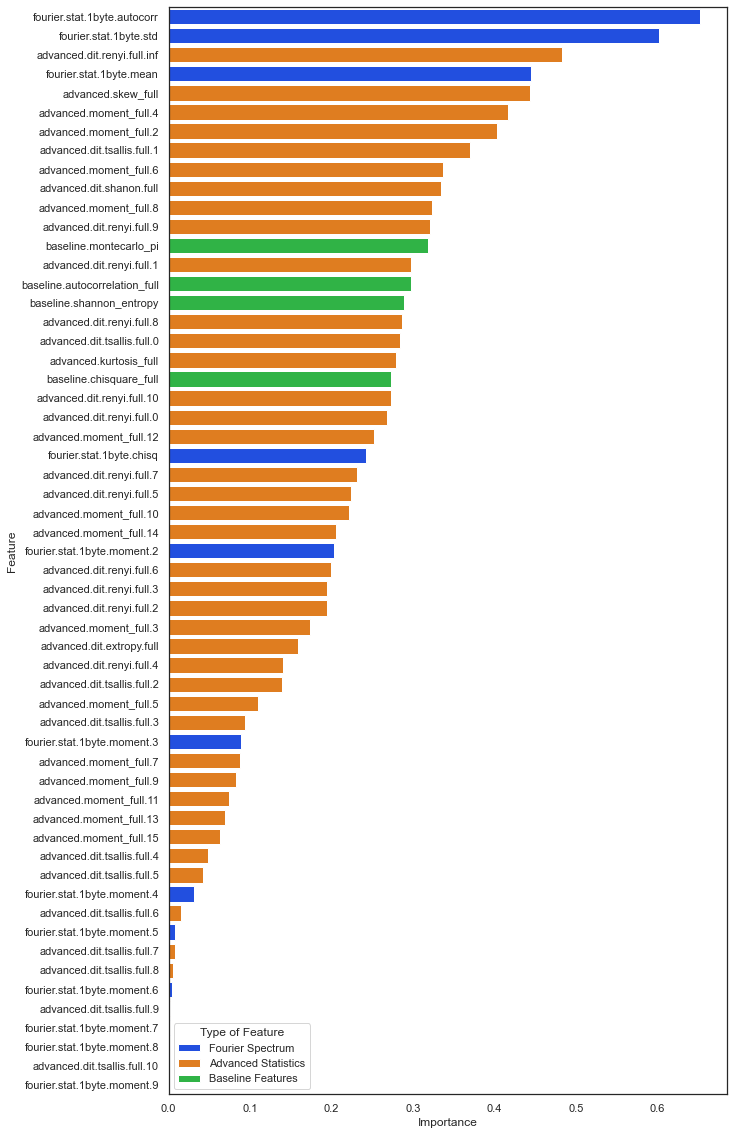

In [12]:
import matplotlib
import seaborn as sns

plt.rcParams["figure.figsize"] = (10,20)
plt.rcParams['font.size'] = 12
plt.rc('font', size=42) 
df2_dict = {"features": columns, "importances": get_weighted_importances_1(all_results)}
imp_df = pd.DataFrame(df2_dict)
imp_df = imp_df.sort_values(by="importances", ascending=False).reset_index(drop="True")
sns.set_theme(style="white")
def select_moments(x):
    if "baseline" in x:
        return "Baseline Features"
    elif "advanced" in x:
        return "Advanced Statistics"
    elif "fourier" in x:
        return "Fourier Spectrum"
    else:
        return "unknown"
sns.color_palette("rocket", as_cmap=True)
imp_df["Type of Feature"] = imp_df["features"].map(select_moments)
imp_df = imp_df[imp_df["importances"] > 0.0005]
imp_df["Feature"] = imp_df["features"]
imp_df["Importance"] = imp_df["importances"]
sns.barplot(y="Feature", x="Importance", data=imp_df, hue="Type of Feature", dodge=False, palette="bright")

### Somewhat different weighted calculation

In the earlier weighted calculation, we had scaled each importance matrix
before calculating the weighted average.
in this one, we don't.


In [13]:
# Redefining this
####
def get_weighted_feature_importances_inloop(f1_scores, feature_importances):
    """
    Redefined function
    
    Next find the weighted mean w.r.t. the f1-score
    """
    out_importances = np.zeros(len(feature_importances[0]))
    for f1, importance in zip(f1_scores, feature_importances):
        # importance = importance / np.max(importance)
        importance = importance * f1
        out_importances = out_importances + importance
    out_importances /= sum(f1_scores)
    return out_importances

all_results = []
list_of_arguments = []

# Get all 8-tuple combinations of T/F
list_of_arguments = [(True,), (False,)]
for i in range(7):
    temp = []
    for e in list_of_arguments:
        et = e + (True,)
        temp.append(et)
        et = e + (False,)
        temp.append(et)
    list_of_arguments = temp

for a, b, c, k, e, f, g, h in tqdm.tqdm(list_of_arguments):
    desc, df, ec, nec = get_dataset(a, b, c, k, e, f, g, h)
    if df is not None:
        result = compare_feature_selections_wrapper(df)
        call_gc()
        result = {**desc, **result}
        result["n_encrypted"] = ec
        result["n_non_encrypted"] = nec
        result["ratio_encrypt_nonencrypt"] = float(ec) / nec
        all_results.append(result)


df_dict = {k:[] for k in all_results[0] if "feature_importance" not in k}
for result in all_results:
    for k, v in result.items():
        if "feature_importances" not in k:
            df_dict[k].append(v)


def get_weighted_importances_1(all_results):
    f1_colname = None
    importance_colname = None
    for k in all_results[0]:
        if "f1_score" in k:
            f1_colname = k
        if "feature_importance" in k:
            importance_colname = k
    f1_scores = []
    importances = []
    print(f1_colname, importance_colname)
    for result in all_results:
        f1_scores.append(result[f1_colname])
        importances.append(result[importance_colname])
    
    out_importances = np.zeros(len(importances[0]))
    for f1, imp in zip(f1_scores, importances):
        out_importances = out_importances + imp * f1
    out_importances = out_importances / sum(f1_scores)
    
    return out_importances

print(get_weighted_importances_1(all_results))


plt.rcParams["figure.figsize"] = (20,20)

columns = get_columns(df[[c for c in df.columns if "is_encrypted" != c]])["fourier"]



100%|██████████████████████████████████████████████████| 256/256 [1:27:36<00:00, 20.54s/it]


fourier-f1_score fourier-feature_importances
[1.93091202e-02 1.28241003e-02 1.02768970e-04 1.61202986e-02
 5.35981387e-03 3.45557712e-03 2.45753039e-02 6.84709638e-03
 1.66004511e-06 6.15583008e-07 3.51907974e-02 8.48424201e-03
 9.99596767e-04 4.32551531e-04 1.29163957e-02 1.11263833e-02
 2.94333414e-04 3.56414944e-03 2.94121229e-02 3.30105414e-02
 3.86253881e-05 1.63516359e-02 7.04414093e-03 1.64319519e-02
 2.74207930e-02 7.93906201e-03 1.83148204e-05 5.90044238e-03
 1.92776165e-02 2.94547095e-02 7.18263060e-03 2.64627923e-02
 5.92404069e-02 7.79554370e-05 2.53934340e-03 2.06991812e-02
 2.73050027e-02 4.08372484e-02 3.96409329e-02 6.21738707e-04
 1.11041191e-02 2.80418431e-02 2.27161281e-02 1.14838453e-05
 3.39638439e-07 2.94148628e-02 2.50565259e-02 2.05189361e-02
 4.80836231e-03 2.56302418e-02 3.94376774e-02 5.24562754e-04
 2.44948034e-02 2.04142809e-02 1.82109127e-02 3.78128246e-02
 8.25807194e-05 2.20088957e-02 1.74409457e-02 1.00925834e-04
 1.59771960e-02 6.36779178e-07 5.7678921

In [14]:
save_results("weighted-results.pickle", columns, all_results)

fourier-f1_score fourier-feature_importances


<AxesSubplot:xlabel='Importance', ylabel='Feature'>

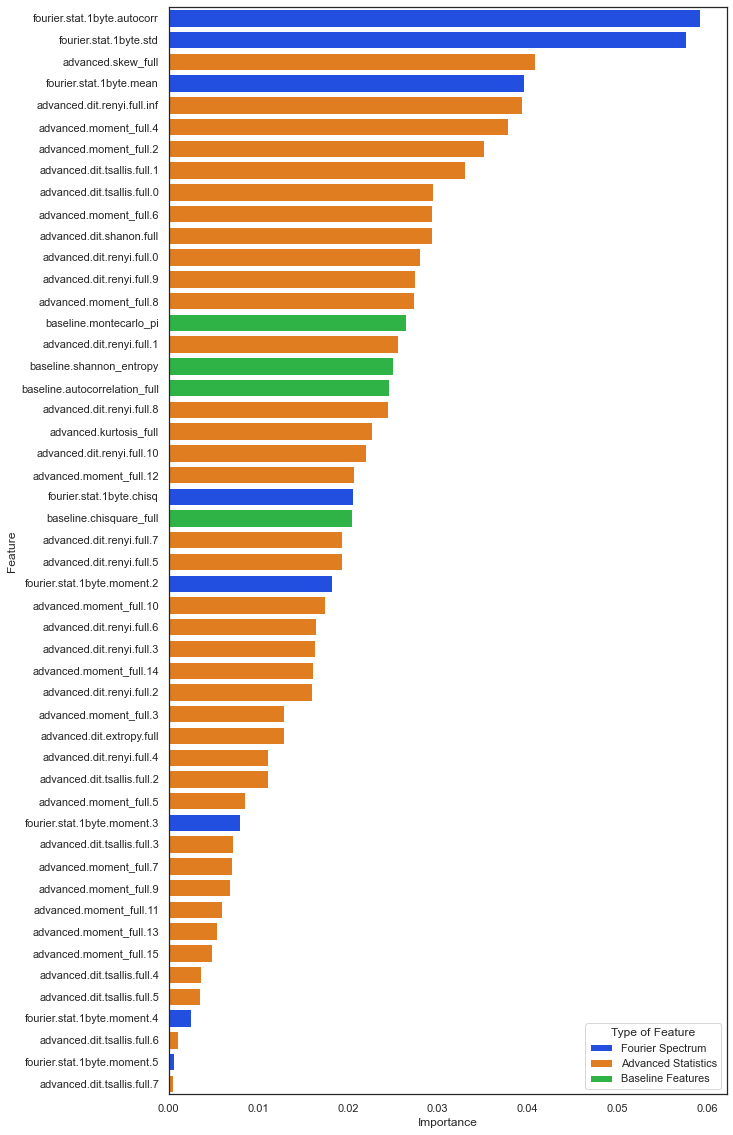

In [15]:
import matplotlib
import seaborn as sns
plt.rcParams["figure.figsize"] = (10,20)
plt.rcParams['font.size'] = 12
plt.rc('font', size=42) 
df2_dict = {"features": columns, "importances": get_weighted_importances_1(all_results)}
imp_df = pd.DataFrame(df2_dict)
imp_df = imp_df.sort_values(by="importances", ascending=False).reset_index(drop="True")
sns.set_theme(style="white")
def select_moments(x):
    if "baseline" in x:
        return "Baseline Features"
    elif "advanced" in x:
        return "Advanced Statistics"
    elif "fourier" in x:
        return "Fourier Spectrum"
    else:
        return "unknown"
sns.color_palette("rocket", as_cmap=True)
imp_df["Type of Feature"] = imp_df["features"].map(select_moments)
imp_df = imp_df[imp_df["importances"] > 0.0005]
imp_df["Feature"] = imp_df["features"]
imp_df["Importance"] = imp_df["importances"]
sns.barplot(y="Feature", x="Importance", data=imp_df, hue="Type of Feature", dodge=False, palette="bright")

### Simple average


In [16]:
# Redefining this
####
def get_weighted_feature_importances_inloop(f1_scores, feature_importances):
    """
    Redefined function
    
    Next find the weighted mean w.r.t. the f1-score
    """
    #print("updated value was called")
    out_importances = np.zeros(len(feature_importances[0]))
    for f1, importance in zip(f1_scores, feature_importances):
        # importance = importance / np.max(importance)
        # importance = importance * f1
        out_importances = out_importances + importance
    out_importances /= len(f1_scores)
    return out_importances

all_results = []
list_of_arguments = []

# Get all 8-tuple combinations of T/F
list_of_arguments = [(True,), (False,)]
for i in range(7):
    temp = []
    for e in list_of_arguments:
        et = e + (True,)
        temp.append(et)
        et = e + (False,)
        temp.append(et)
    list_of_arguments = temp

for a, b, c, k, e, f, g, h in tqdm.tqdm(list_of_arguments):
    desc, df, ec, nec = get_dataset(a, b, c, k, e, f, g, h)
    if df is not None:
        result = compare_feature_selections_wrapper(df)
        call_gc()
        result = {**desc, **result}
        result["n_encrypted"] = ec
        result["n_non_encrypted"] = nec
        result["ratio_encrypt_nonencrypt"] = float(ec) / nec
        all_results.append(result)


df_dict = {k:[] for k in all_results[0] if "feature_importance" not in k}
for result in all_results:
    for k, v in result.items():
        if "feature_importances" not in k:
            df_dict[k].append(v)


def get_weighted_importances_1(all_results):
    f1_colname = None
    importance_colname = None
    for k in all_results[0]:
        if "f1_score" in k:
            f1_colname = k
        if "feature_importance" in k:
            importance_colname = k
    f1_scores = []
    importances = []
    print(f1_colname, importance_colname)
    for result in all_results:
        f1_scores.append(result[f1_colname])
        importances.append(result[importance_colname])
    
    out_importances = np.zeros(len(importances[0]))
    for f1, imp in zip(f1_scores, importances):
        out_importances = out_importances + imp
    out_importances = out_importances / len(f1_scores)
    
    return out_importances

print(get_weighted_importances_1(all_results))


plt.rcParams["figure.figsize"] = (20,20)

columns = get_columns(df[[c for c in df.columns if "is_encrypted" != c]])["fourier"]



100%|██████████████████████████████████████████████████| 256/256 [1:23:15<00:00, 19.51s/it]


fourier-f1_score fourier-feature_importances
[1.94062001e-02 1.29546840e-02 1.13228025e-04 1.64107249e-02
 5.48745135e-03 3.55128762e-03 2.47650569e-02 6.89808843e-03
 1.87209978e-06 6.95175014e-07 3.50555919e-02 8.77268665e-03
 1.09094272e-03 4.63443687e-04 1.35358168e-02 1.13589271e-02
 3.11364209e-04 3.76124665e-03 2.92242615e-02 3.26533034e-02
 4.16724515e-05 1.63846667e-02 7.19161481e-03 1.65729183e-02
 2.73630071e-02 7.95921675e-03 1.92770009e-05 5.99233027e-03
 1.92624788e-02 2.82069058e-02 7.41033226e-03 2.67294979e-02
 5.85864406e-02 8.11838242e-05 2.61643775e-03 2.07632647e-02
 2.70506665e-02 4.01821871e-02 3.95686292e-02 6.53813595e-04
 1.13196189e-02 2.68421227e-02 2.30064972e-02 1.22540862e-05
 3.69582246e-07 2.91721932e-02 2.50163574e-02 2.08882199e-02
 4.96525653e-03 2.55736313e-02 4.00085870e-02 5.74807780e-04
 2.44758115e-02 2.12515168e-02 1.82543964e-02 3.73027891e-02
 8.44071916e-05 2.23005212e-02 1.76386253e-02 1.05741306e-04
 1.60676058e-02 6.99859764e-07 5.6684555

In [17]:
save_results("simple-average.pickle", columns, all_results)

fourier-f1_score fourier-feature_importances


<AxesSubplot:xlabel='Importance', ylabel='Feature'>

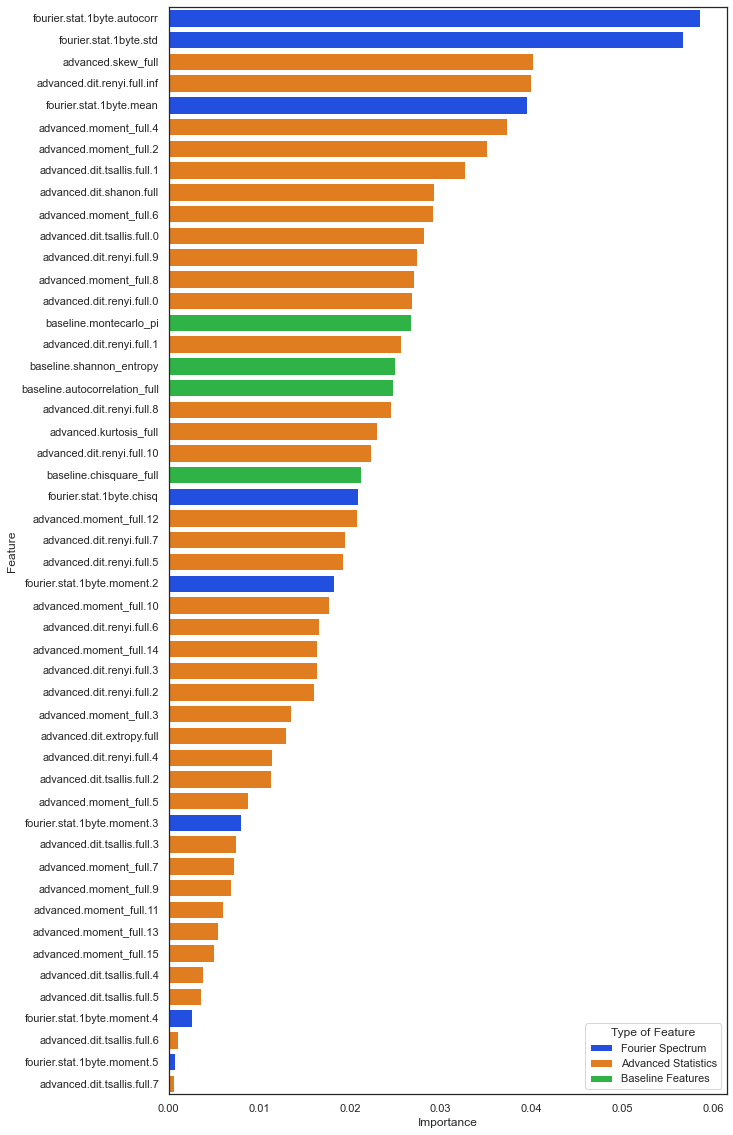

In [18]:
import matplotlib
import seaborn as sns
plt.rcParams["figure.figsize"] = (10,20)
plt.rcParams['font.size'] = 12
plt.rc('font', size=42) 
df2_dict = {"features": columns, "importances": get_weighted_importances_1(all_results)}
imp_df = pd.DataFrame(df2_dict)
imp_df = imp_df.sort_values(by="importances", ascending=False).reset_index(drop="True")
sns.set_theme(style="white")
def select_moments(x):
    if "baseline" in x:
        return "Baseline Features"
    elif "advanced" in x:
        return "Advanced Statistics"
    elif "fourier" in x:
        return "Fourier Spectrum"
    else:
        return "unknown"
sns.color_palette("rocket", as_cmap=True)
imp_df["Type of Feature"] = imp_df["features"].map(select_moments)
imp_df = imp_df[imp_df["importances"] > 0.0005]
imp_df["Feature"] = imp_df["features"]
imp_df["Importance"] = imp_df["importances"]
sns.barplot(y="Feature", x="Importance", data=imp_df, hue="Type of Feature", dodge=False, palette="bright")